In [1]:
import numpy as np
import h5py
from glob import glob
import os
import matplotlib.pyplot as plt

In [2]:
def load_data(acq, 
              data_path, 
              gains_path,
              prod_sel = None,
              freq_sel = None,
              file_sel = None,
              time_bounds = None,
              inputs = None,
              trim_non_valid_data = True,
              apply_counts = True,
              apply_gains = True,
              ):
    
    if prod_sel is not None:
        raise ValueError('prod_sel not yet fully tested')
        
    if freq_sel is not None:
        raise ValueError('freq_sel not yet fully tested')
        
    if file_sel is not None:
        raise ValueError('file_sel not yet fully tested')
        
    if time_bounds is not None:
        raise ValueError('time_bounds not yet fully tested')
        
    if inputs is not None:
        raise ValueError('inputs not yet fully tested')
   
    # Load data arrays
    N_FILES = len(os.listdir(f'{data_path}/{acq}'))
    #print(f'{data_path}/{acq}')
    
    for n in range(N_FILES):
        print(f'Loading data file {data_path}/{acq}/{n}.hdf5')
        df = h5py.File(f'{data_path}/{acq}/{n}.hdf5', 'r')
        
        # Gather the products and frequencies from the first data file only,
        # since we don't need to load this more than once
        if n == 0:
            prod = df['index_map']['prod'][:]
            # by default, load all products
            if (prod_sel is None) and (inputs is None):
                prod_sel = np.arange(len(prod), dtype=np.int)
            # inputs overrides prod sel
            elif inputs is not None:
                prod_sel = []
                for ii,pp in enumerate(prod):
                    if (pp[0] in inputs) and (pp[1] in inputs):
                        prod_sel.append(ii)
                prod_sel = np.array(prod_sel, dtype=np.int)
                prod = prod[prod_sel]
            else:
                prod = prod[prod_sel]
                
            f = df['index_map']['freq'][:] # [freq_sel]

            N_PRODS = len(prod)

            n_firmware_frames = df['vis'].attrs['n_firmware_frames']
            n_software_frames = df['vis'].attrs['n_software_frames']

            vis_all = df['vis'][:]
            counts_all = df['counts'][:]
            sat_all = df['sat'][:]
            t_all = df['index_map']['time'][:]

            adc_overflows_all = df['stats']['adc_overflows'][:]
            corr_overrun_all = df['stats']['corr_overrun'][:]
            fft_overflows_all = df['stats']['fft_overflows'][:]
            frame_count_all = df['stats']['frame_count'][:]
            scaler_overflows_all = df['stats']['scaler_overflows'][:]
            
        else:
            vis_all = np.concatenate((vis_all, df['vis'][:]))
            counts_all = np.concatenate((counts_all, df['counts'][:]))
            sat_all = np.concatenate((sat_all, df['sat'][:]))
            t_all = np.concatenate((t_all, df['index_map']['time'][:]))

            adc_overflows_all = np.concatenate((adc_overflows_all, df['stats']['adc_overflows'][:]))
            corr_overrun_all = np.concatenate((corr_overrun_all, df['stats']['corr_overrun'][:]))
            fft_overflows_all = np.concatenate((fft_overflows_all, df['stats']['fft_overflows'][:]))
            frame_count_all = np.concatenate((frame_count_all, df['stats']['frame_count'][:]))
            scaler_overflows_all = np.concatenate((scaler_overflows_all, df['stats']['scaler_overflows'][:]))

        # Close file
        df.close()

    if trim_non_valid_data:

        # Determine which indices need to be trimmed, based on whether or not they have all their expected counts. We also trim
        # the first four bins by default because they are not sent by the RFSoC anyways.
        delete_capture_idx = []
        for n in range(counts_all.shape[0]):
            # print(n, len(np.where(counts_all[n, 4:] != vis_1s_nsf)[0]), counts_all[n, 4:][np.where(counts_all[n, 4:] != n_software_frames)[0]])
            if not all(counts_all[n, 4:] == n_software_frames):
                delete_capture_idx.append(n)

        # Trim data accordingly.

        # Data
        f = np.copy(f[4:])
        vis_all = np.delete(vis_all[:, 4:], delete_capture_idx, axis = 0)
        counts_all = np.delete(counts_all[:, 4:], delete_capture_idx, axis = 0)
        sat_all = np.delete(sat_all[:, 4:], delete_capture_idx, axis = 0)
        t_all = np.delete(t_all, delete_capture_idx, axis = 0)
        
        # Statistics
        adc_overflows_all = np.delete(adc_overflows_all, delete_capture_idx, axis = 0)
        corr_overrun_all = np.delete(corr_overrun_all, delete_capture_idx, axis = 0)
        fft_overflows_all = np.delete(fft_overflows_all, delete_capture_idx, axis = 0)
        scaler_overflows_all = np.delete(scaler_overflows_all, delete_capture_idx, axis = 0)

        # Print a sanity check that all the counts are valid for the trimmed datasets
        # print(counts_trim)
        if all(counts_all.flatten() == n_software_frames):
            print(f'All counts have the expected {n_software_frames} software frames after trimming.')
        else:
            print(f'WARNING! Not all counts have the expected {n_software_frames} software frames after trimming.')

    if apply_counts:
        total_frames = counts_all * n_firmware_frames        
        for n in range(N_PRODS):
            vis_all[..., n] /= total_frames

    if apply_gains:    

        # Load gains
        print(f'Loading gain file {gains_path}/{acq}_digitalgain/gains.hdf5')
        gf = h5py.File(f'{gains_path}/{acq}_digitalgain/gains.hdf5', 'r')
    
        glin = gf['lin'][:].astype(np.float64) # cast to float64 so operations with these arrays are correct
        glog = gf['log'][:].astype(np.float64)
    
        gf.close()

        if trim_non_valid_data:
            # Remove first 4 bins from inear gain
            glin = glin[:, 4:]
        
        for n in range(N_PRODS):
            idx0 = prod[n][0]
            idx1 = prod[n][1]
            for m in range(vis_all.shape[0]):
                vis_all[m, :, n] /= ((glin[idx0] * 2**glog[idx0]) * (glin[idx1] * 2**glog[idx1]))

    return (vis_all, 
            f,
            prod,
            t_all, 
            counts_all, 
            glin, 
            glog,
            sat_all,
            adc_overflows_all, 
            fft_overflows_all, 
            scaler_overflows_all, 
            corr_overrun_all, 
            frame_count_all
           )

from Ian:

yes it's not the same load acq as before

you can use 20240824T200505Z_D3A_rfsoc as the acq, but since I just grabbed one data file you don't have a directory with that acq.

so you need to put 0.hdf5 in a folder named 20240824T200505Z_D3A_rfsoc, and the digital gains file in a folder named 20240824T200505Z_D3A_rfsoc_digitalgain

so maybe something like

make a top-level folder called D3A_acq

inside, make your 20240824T200505Z_D3A_rfsoc folder

then make your 20240824T200505Z_D3A_rfsoc_digitalgain folder in D3A_acq too

then data_path = f'/path/to/D3A_acq/{acq}'

and gains_path = f'/path/to/D3A_acq/{acq}_digitalgain'

In [4]:
#which data to load
#link = "/mnt/c/users/'Kit M. Gerodias'/Documents/McGill_Cosmology/Drones/'crs data'/"
link = "/mnt/c/users/Kit M. Gerodias/Documents/McGill_Cosmology/Drones/crs data/"
date = "20240824T200505Z"
data = date + "_D3A_rfsoc"
gain = data + "_digitalgain"


data_path = link + data
gains_path = link + gain


data_pack = load_data(data, data_path,gains_path)

Loading data file /mnt/c/users/Kit M. Gerodias/Documents/McGill_Cosmology/Drones/crs data/20240824T200505Z_D3A_rfsoc/20240824T200505Z_D3A_rfsoc/0.hdf5


/tmp/ipykernel_4135/1964636372.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prod_sel = np.arange(len(prod), dtype=np.int)


All counts have the expected 119 software frames after trimming.
Loading gain file /mnt/c/users/Kit M. Gerodias/Documents/McGill_Cosmology/Drones/crs data/20240824T200505Z_D3A_rfsoc_digitalgain/20240824T200505Z_D3A_rfsoc_digitalgain/gains.hdf5


/tmp/ipykernel_4135/1964636372.py:144: RuntimeWarning: invalid value encountered in divide
  vis_all[m, :, n] /= ((glin[idx0] * 2**glog[idx0]) * (glin[idx1] * 2**glog[idx1]))
/tmp/ipykernel_4135/1964636372.py:144: RuntimeWarning: divide by zero encountered in divide
  vis_all[m, :, n] /= ((glin[idx0] * 2**glog[idx0]) * (glin[idx1] * 2**glog[idx1]))


In [5]:
gains_path

'/mnt/c/users/Kit M. Gerodias/Documents/McGill_Cosmology/Drones/crs data/20240824T200505Z_D3A_rfsoc_digitalgain'

In [6]:
len(data_pack)

13

In [7]:
freq = data_pack[1]

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


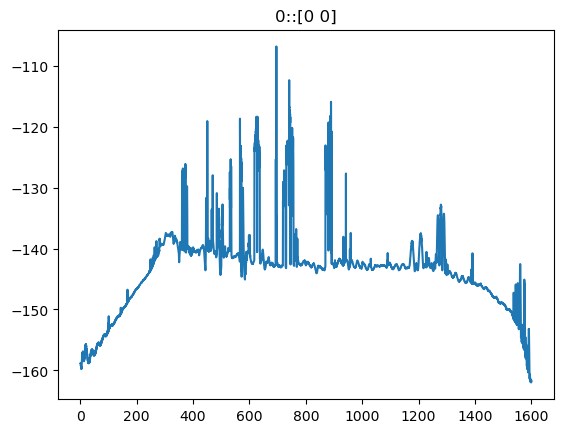

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


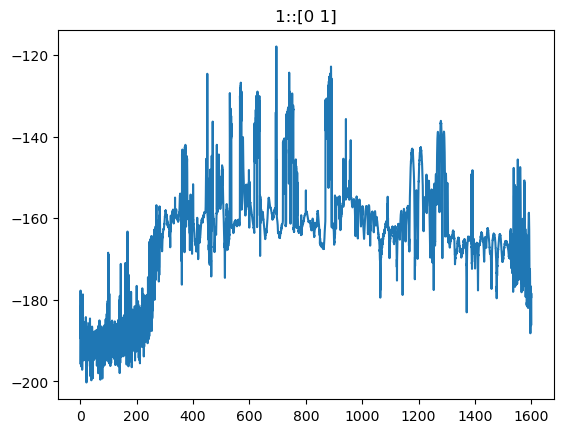

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


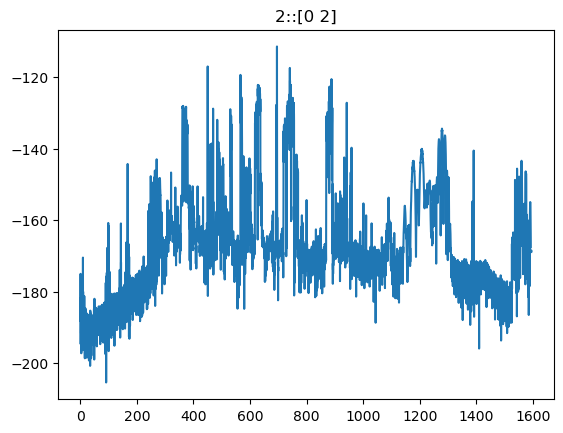

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


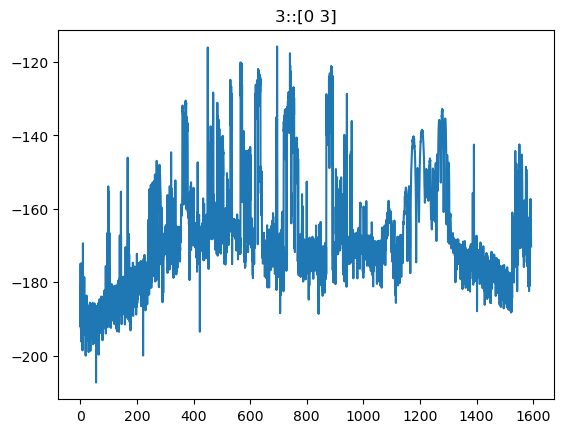

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


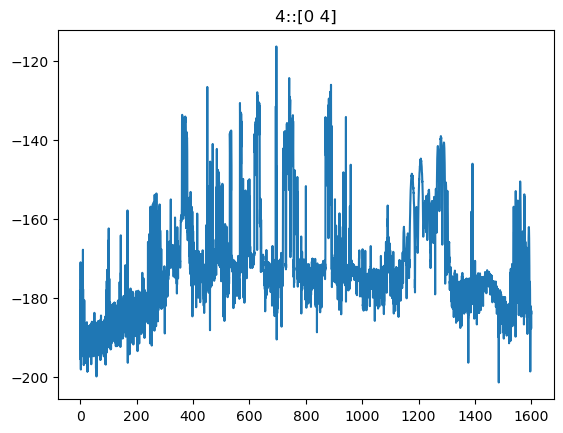

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


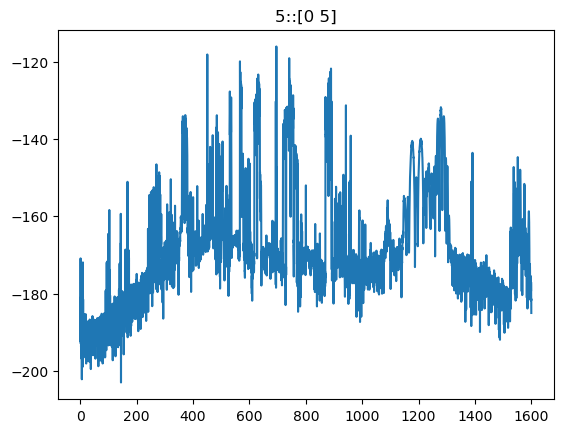

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


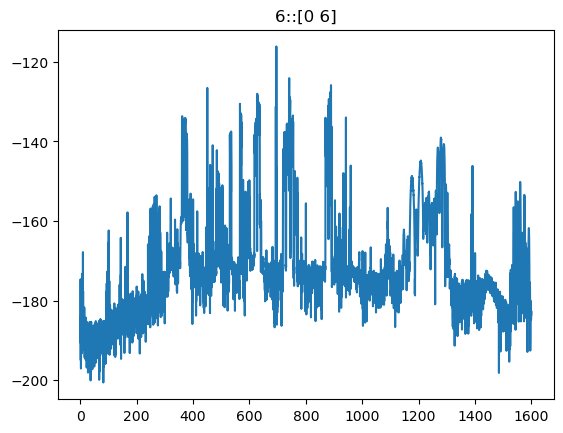

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


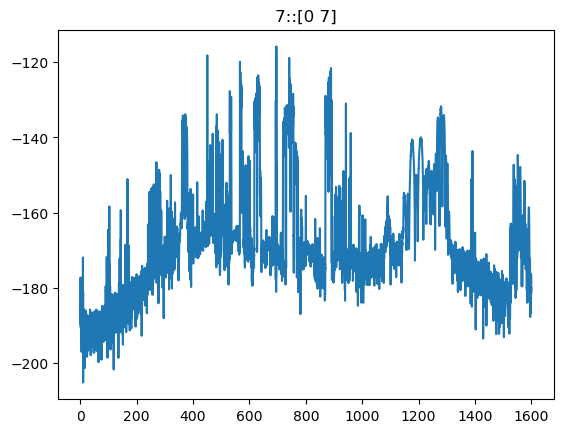

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


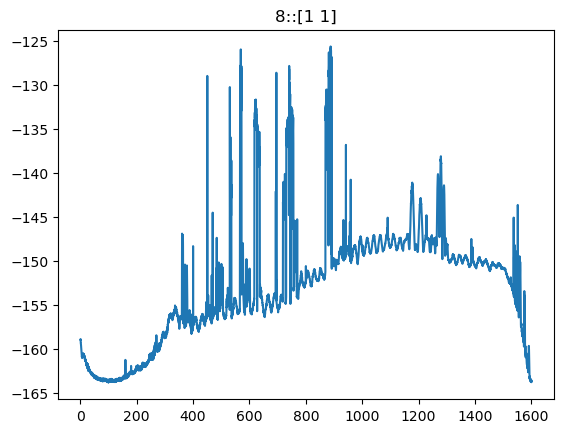

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


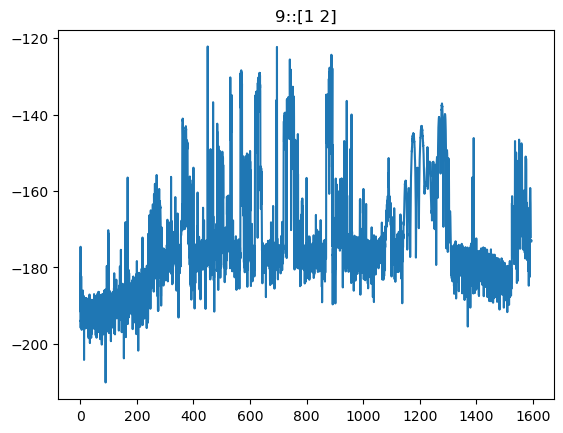

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


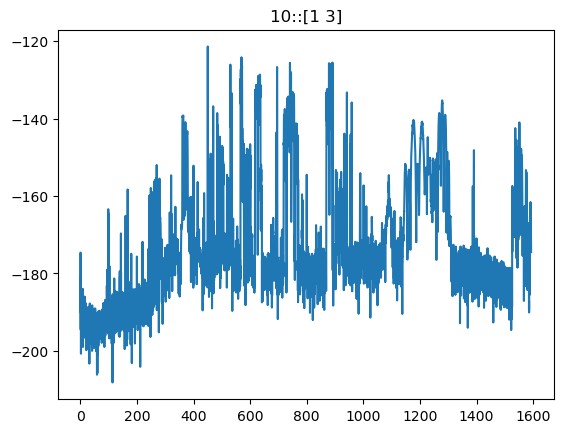

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


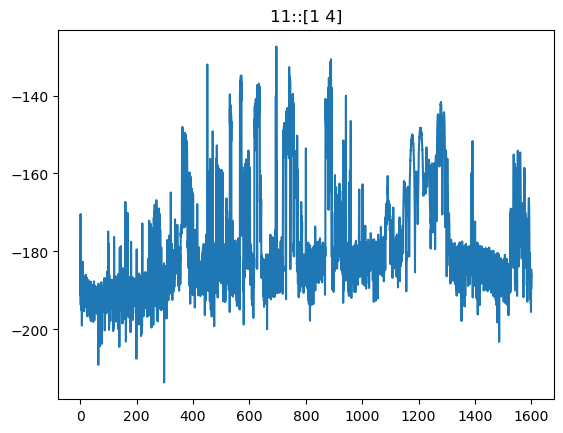

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


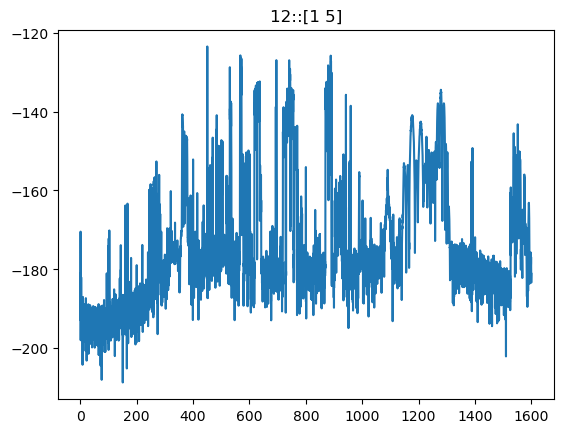

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


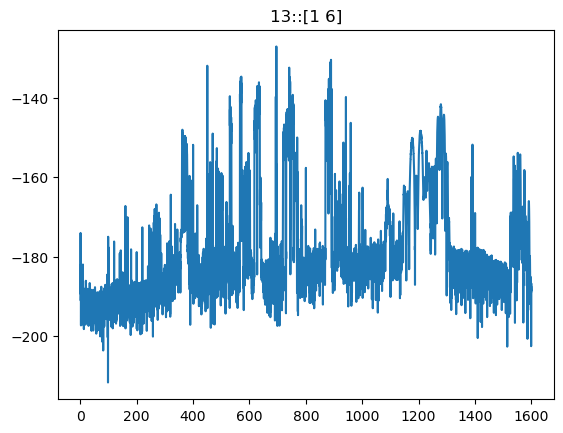

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


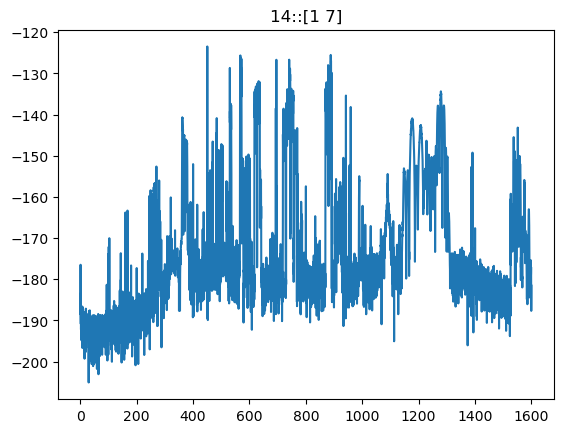

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


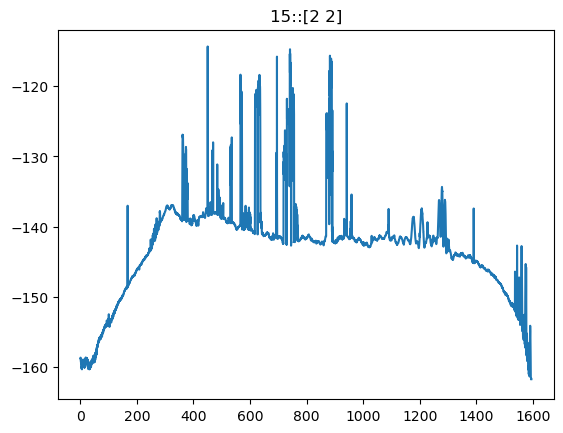

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


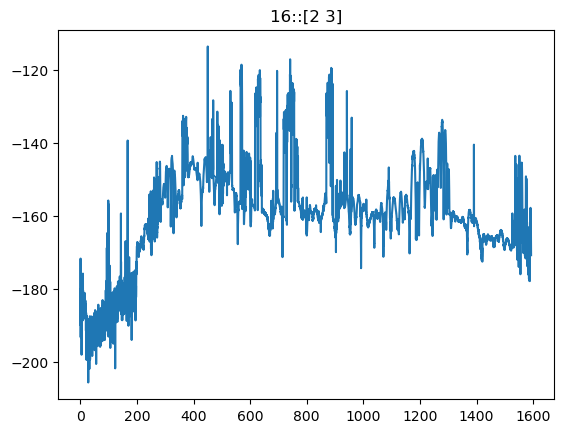

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


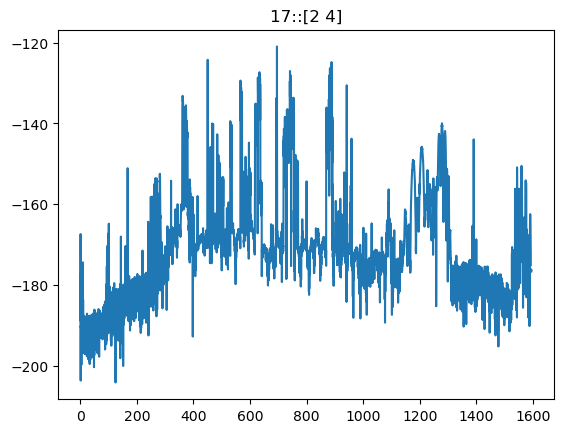

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


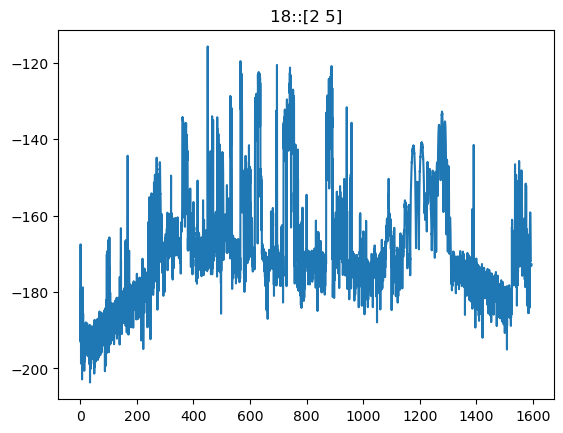

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


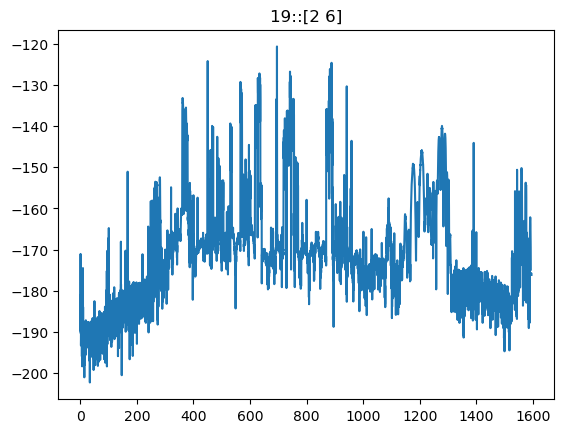

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


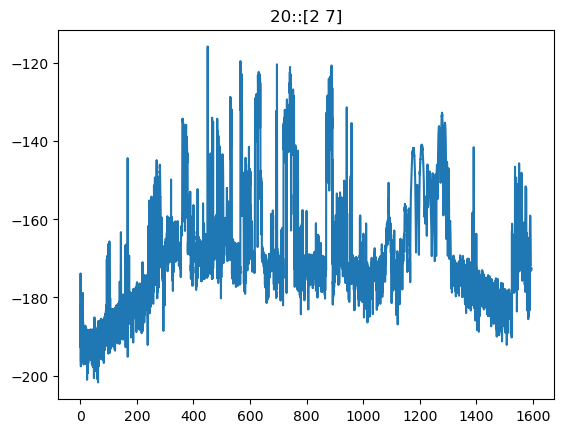

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


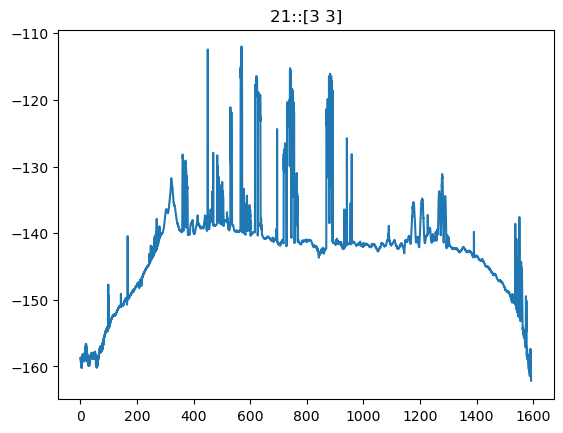

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


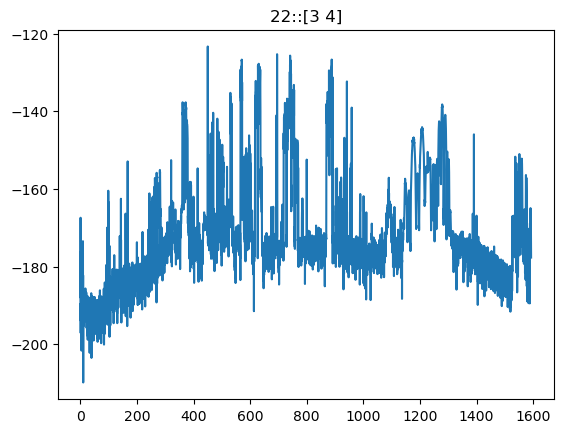

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


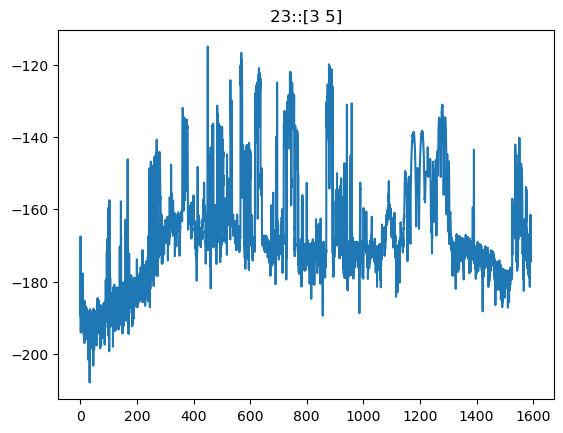

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


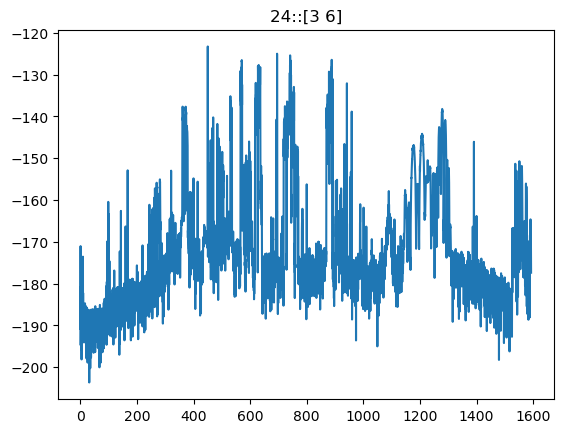

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


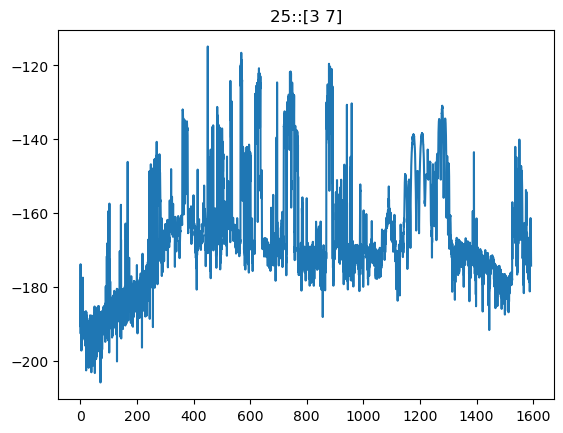

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


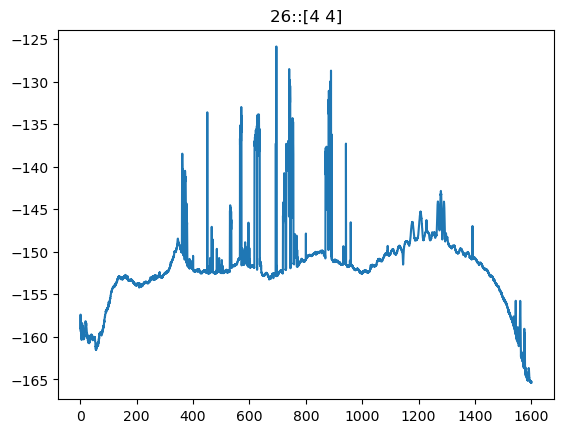

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


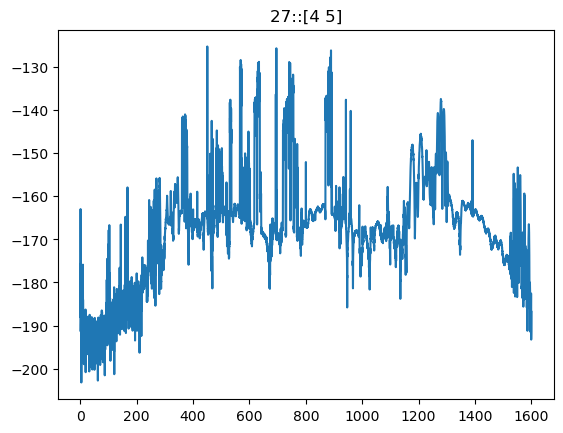

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


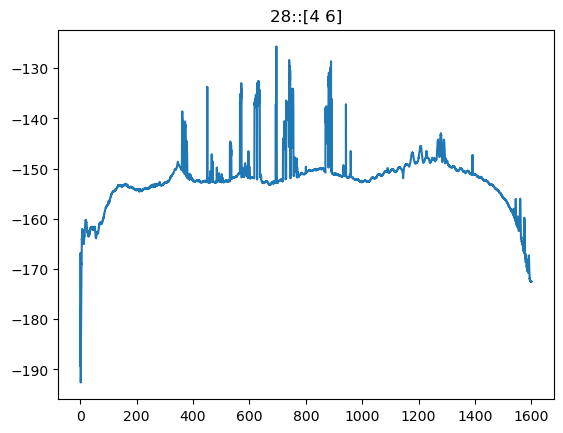

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


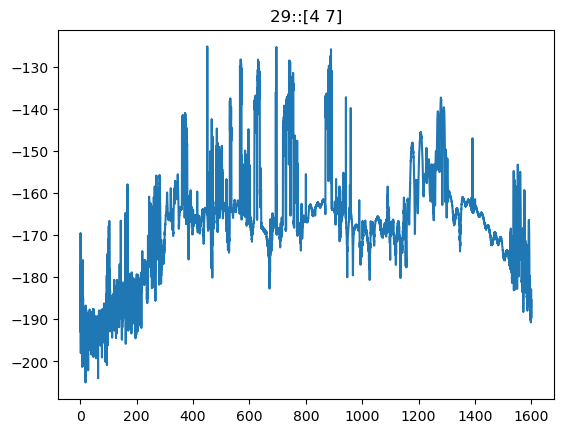

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


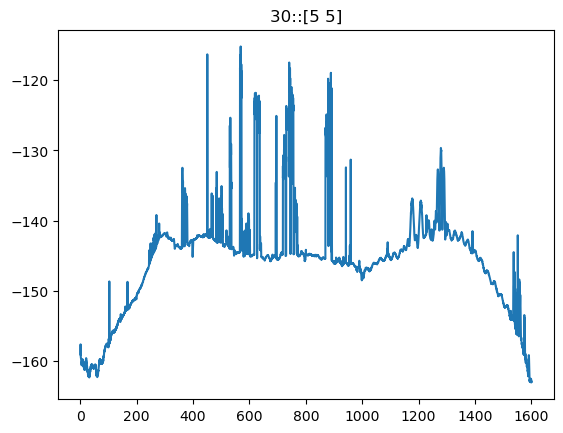

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


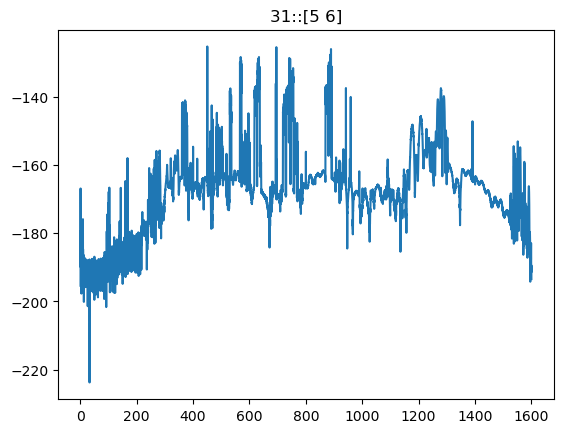

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


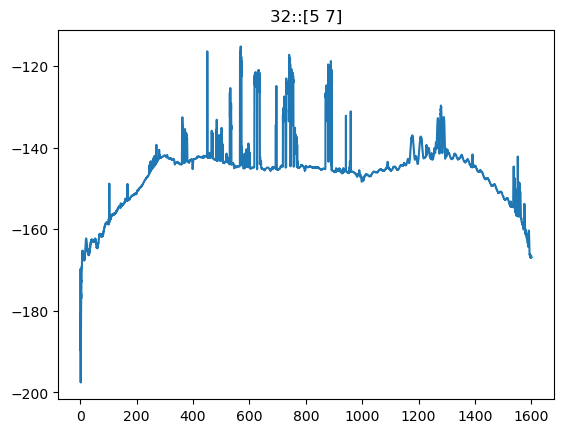

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


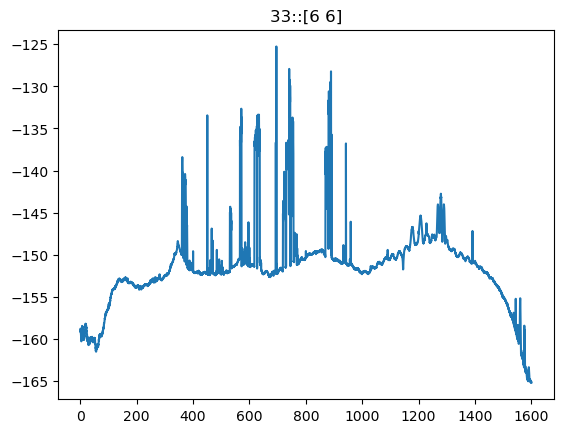

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


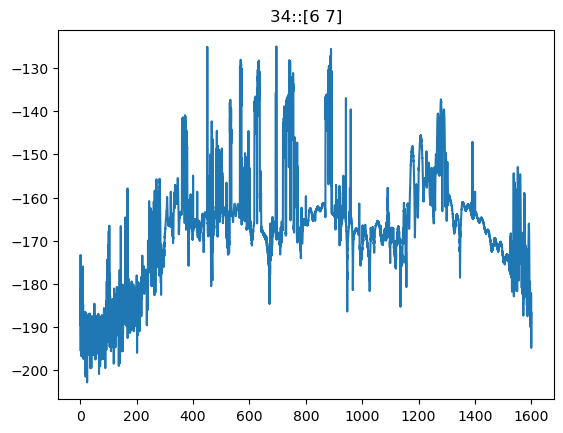

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


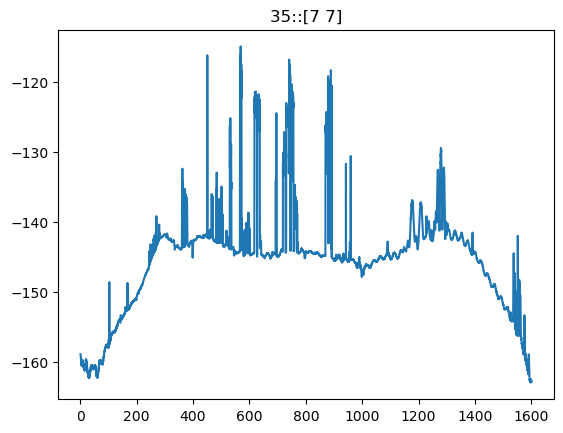

In [76]:
for i in range(len(data_pack[2][:,0])):
    plt.plot(freq, 10*np.log10(data_pack[0][0][:,i]))
    title = str(i) + '::' + str(data_pack[2][i])
    plt.title(title)
    plt.show()

index [input, input]\
0 [0,0]\
8 [1,1]\
15 [2,2]\
21 [3,3]\
26 [4,4]\
30 [5,5]\
33 [6,6]\
35 [7,7]

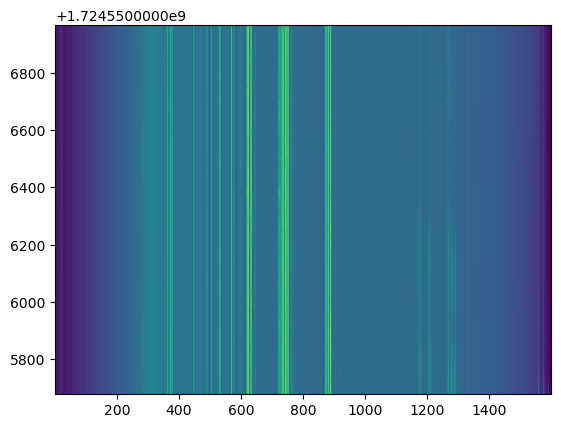

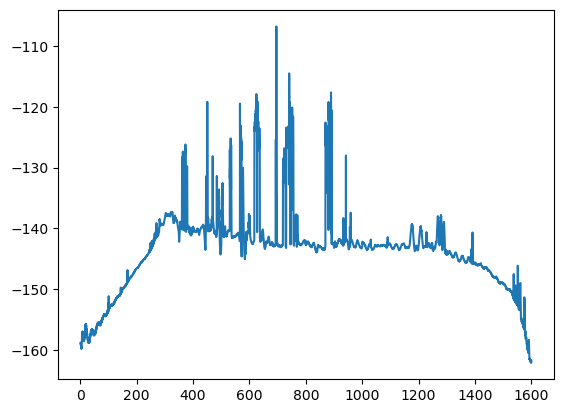

In [8]:

plt.pcolormesh(freq, data_pack[3], 10*np.log10(np.abs(data_pack[0][:,:,0])))
plt.show()

plt.plot(freq, 10*np.log10(np.mean(np.abs(data_pack[0][:,:,0]), axis=0)))
plt.show()

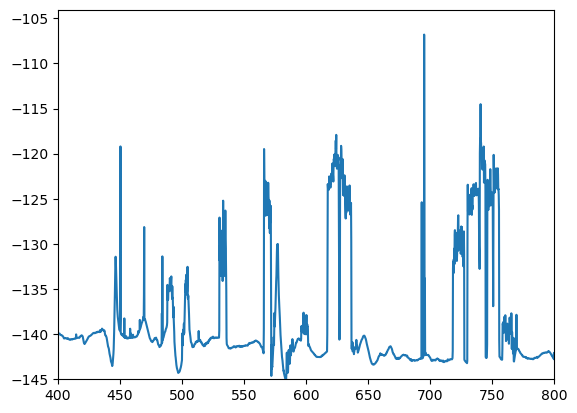

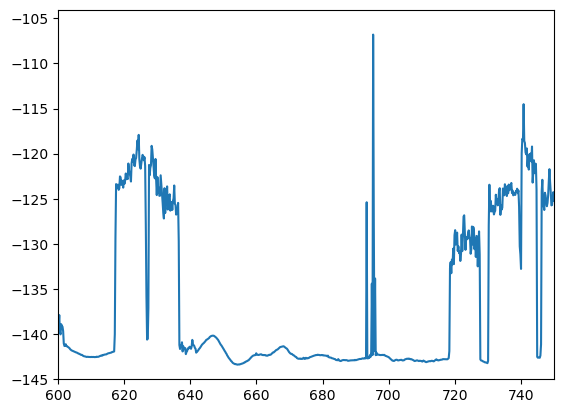

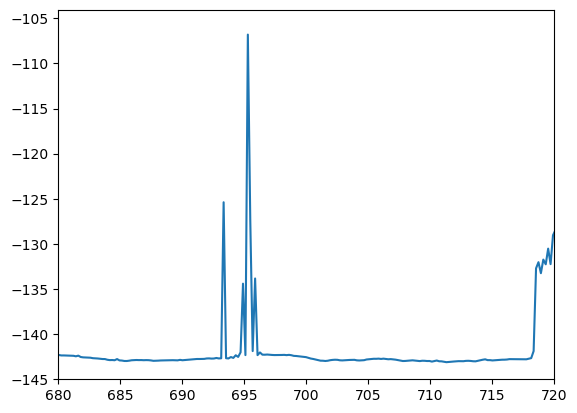

In [142]:
plt.plot(freq, 10*np.log10(np.mean(np.abs(data_pack[0][:,:,0]), axis=0)))
plt.xlim(400,800)
plt.ylim(-145)
plt.show()

plt.plot(freq, 10*np.log10(np.mean(np.abs(data_pack[0][:,:,0]), axis=0)))
plt.xlim(600,750)
plt.ylim(-145)
plt.show()



plt.plot(freq, 10*np.log10(np.mean(np.abs(data_pack[0][:,:,0]), axis=0)))
plt.xlim(680,720)
plt.ylim(-145)
plt.show()

In [143]:
wanted_freq = 705
wanted_freq_idx = np.argmin(np.abs(freq-wanted_freq))
freq[wanted_freq_idx]

705.078125

In [144]:
wanted_freq_idx

3606

In [145]:
print(freq[wanted_freq_idx-3])
print(freq[wanted_freq_idx-2])
print(freq[wanted_freq_idx-1])
print(freq[wanted_freq_idx])
print(freq[wanted_freq_idx+1])
print(freq[wanted_freq_idx+2])
print(freq[wanted_freq_idx+3])

704.4921875
704.6875
704.8828125
705.078125
705.2734375
705.46875
705.6640625


In [146]:
freq[wanted_freq_idx]-freq[wanted_freq_idx-1]

0.1953125

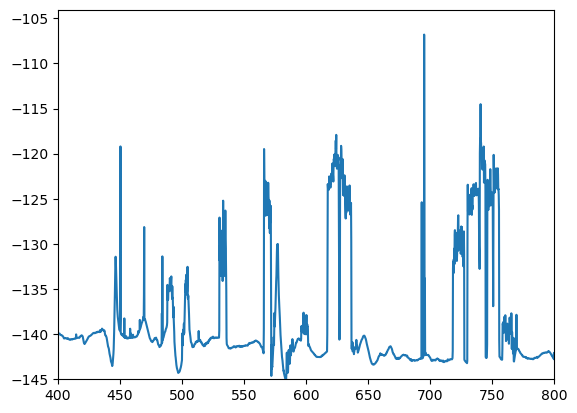

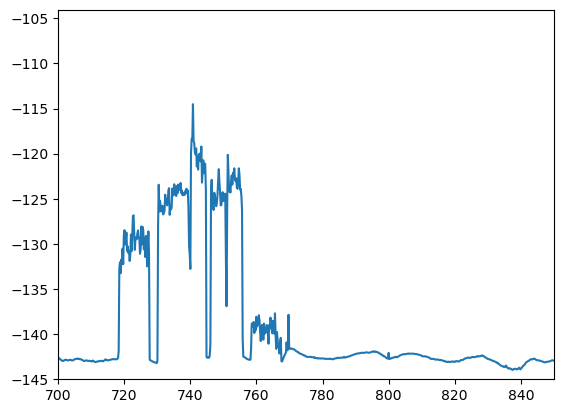

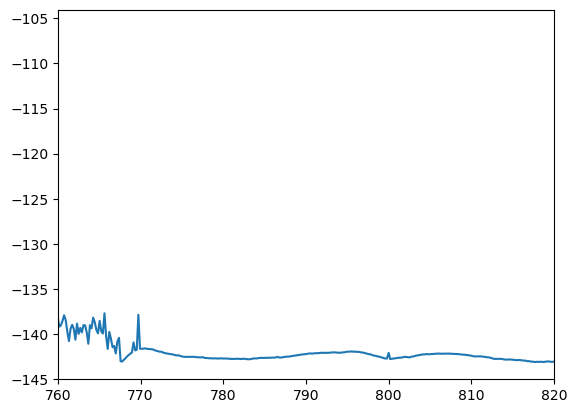

In [148]:
plt.plot(freq, 10*np.log10(np.mean(np.abs(data_pack[0][:,:,0]), axis=0)))
plt.xlim(400,800)
plt.ylim(-145)
plt.show()

plt.plot(freq, 10*np.log10(np.mean(np.abs(data_pack[0][:,:,0]), axis=0)))
plt.xlim(700,850)
plt.ylim(-145)
plt.show()

plt.plot(freq, 10*np.log10(np.mean(np.abs(data_pack[0][:,:,0]), axis=0)))
plt.xlim(760,820)
plt.ylim(-145)
plt.show()